# Assignment Sheet 2

Bruce Schultz  
bschultz@uni-bonn.de

Miguel A. Ibarra-Arellano  
ibarrarellano@gmail.com

## Exercise 1

In [2]:
# Requiered libraries
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from itertools import product

In [3]:
def interpolate_by_mean(column):
    """
    Interpolates missing values by the mean
    :param column: A pandas dataframe
    :return: A pandas dataframe containing the column names which have null values
    """
    return column.fillna(int(round(column.mean()))) if any(column.isnull()) else column

In [4]:
def get_f_score (attribute, groups, exclude =[]):
    """
    Calculates the F score of an attribute between to groups (for now)
    :param data: Pandas dataframe
    :param column: Pandas Series
    :param groupby: Column with the categories
    :param exclude: List of columns to be excluded from the calculation
    """
    if attribute.name in exclude:
        return None
    else:        
        # Get means for groups
        grand_mean = attribute.mean()
        g1_mean = groups[0][attribute.name].mean() # Group 1
        g2_mean = groups[1][attribute.name].mean() # Group 2
        
        g1_diff = [(i-g1_mean)**2 for i in groups[0][attribute.name]] # Group 1
        g2_diff = [(i-g2_mean)**2 for i in groups[1][attribute.name]] # Group 2
        
        numerator = (g1_mean - grand_mean)**2 + (g2_mean - grand_mean)**2
        denom = (1/(len(groups[0][attribute.name])-1))*sum(g1_diff) + \
                (1/(len(groups[1][attribute.name])-1))*sum(g2_diff)
        
        return numerator/denom

In [5]:
def cluster_center(points):
    '''
    Computes the center point from a list of points
    :param points: Can be a list of lists of tuples containing points
    :return: A list with center point for each set of points provided, in numpy array format
    '''
    cluster_centers = [np.array([0, 0]) for dataset in points]
    for i in range(len(points)):
        for datapoint in points[i]:
            cluster_centers[i] = np.add(np.array(datapoint), cluster_centers[i])
        cluster_centers[i] = cluster_centers[i]/len(points[i])
    return cluster_centers

In [6]:
def DSC(point_list):
    '''
    Computers Distance consistency for a set (or sets) of points
    :param point_list: A list of points in tuple format
    :return: Numerical computation of the Distance consistency for all points provided
    '''
    # First computer center points
    centers = cluster_center(point_list)
    #Create empty lists to store distances of the difference between each point and each centroid
    same_cluster_distances = []
    diff_cluster_distances = []
    for i in range(len(point_list)):
        for datapoint in point_list[i]:
            for j in range(len(point_list)):
                # Alternate between same centroid and diff centroids, store in list
                if i == j:
                    same_cluster_distances.append(np.linalg.norm(np.array(datapoint) - centers[i]))
                else:
                    diff_cluster_distances.append(np.linalg.norm(np.array(datapoint) - centers[j]))
    # Create counter to keep track points closer to their own centroid
    closer_points = 0
    for k in range(len(same_cluster_distances)):
        if same_cluster_distances[k] < diff_cluster_distances[k]:
            closer_points += 1
    return (100*closer_points/len(same_cluster_distances))

C:\Users\Bruce\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


The highest distance consistancy is 94.70672389127324 and found between thickness and uniCelShape


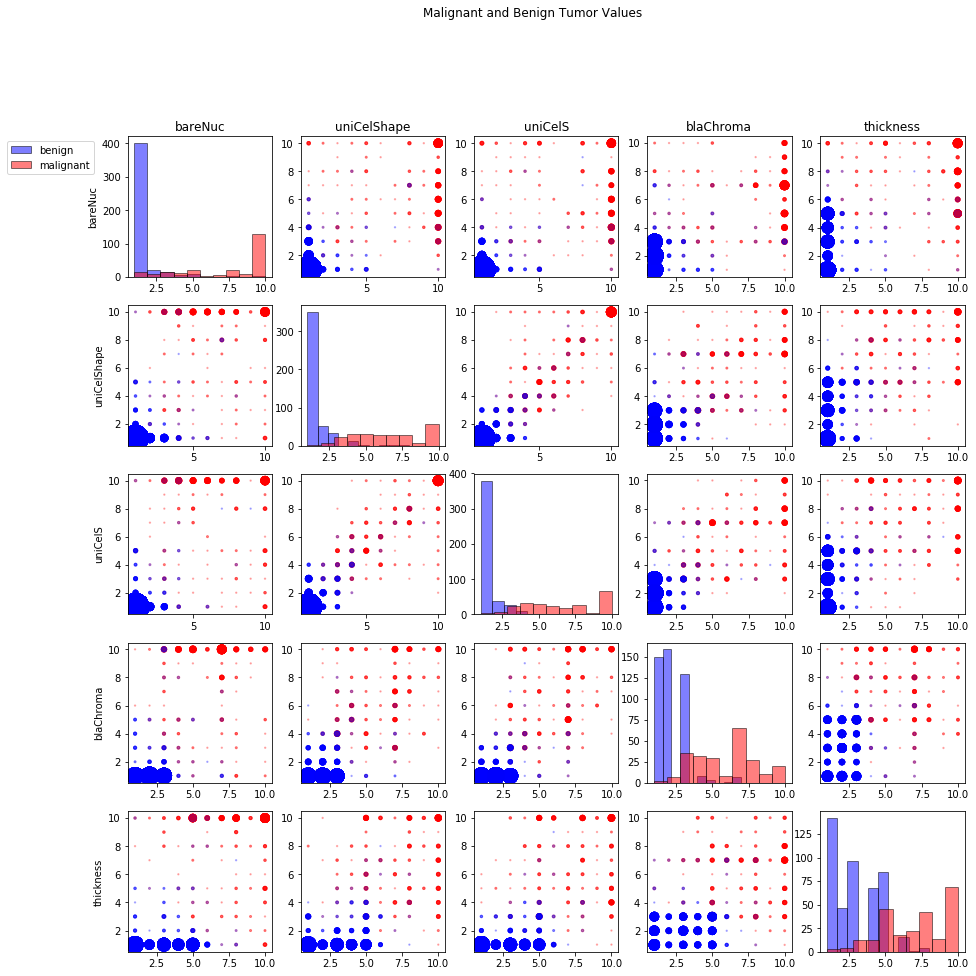

In [7]:
def scat_matrix(filepath, num_attr):
    '''
    Generates scatterplots of the attribute combinations that had the highest num_attr F scores \
    in the non-diagonal spots and histograms of the benign and malignant frequencies for each attr. \
    Also calculates distance consistency for every combination of attributes used and prints out results
    :param filepath: Filepath destination to the data
    :param num_attr: Number of attributes to be used in graphs
    :return:
    '''
    # Read file to pandasDF
    data_df = pd.read_excel(os.path.abspath(filepath), index_col="code")

    # For the moment let's just interpolate missing data by class
    # Interpolating missing values to each column
    benign_imputed = data_df[data_df["class"]==2].apply(interpolate_by_mean, axis=0)
    malig_imputed = data_df[data_df["class"]==4].apply(interpolate_by_mean, axis=0)
    data_imputed = pd.concat([malig_imputed, benign_imputed])

    # Calculate F-Score for the imputed data
    fscores = data_imputed.apply(get_f_score, axis=0, exclude=["class"],
                                 groups=[benign_imputed, malig_imputed])

    # Sort fscores
    fscores = fscores.sort_values(ascending=False)

    # Subset data based on most significant attributes
    # Generate figure for plots to be plotted in
    n = num_attr  # Number of attributes to be used
    fig, subs = plt.subplots(n, n, figsize=(15, 15))

    # zip together the column names and the position on the matrix
    # this will avoid using nested loops
    col = product(fscores[:n].index, repeat=2)
    idx = product(range(n), repeat=2)

    # Create colors list
    colors = ["blue" if row is 2 else "red" for row in list(data_imputed['class'])]

    # Collect DSC values
    DSC_values = []

    # iterate over columns(c1,c2) combinations and plot
    for attr, idx in zip(col, idx):
        # Unpacking values
        i, j = idx
        attrx, attry = attr

        if i == j:
            subs[i, j].hist(data_imputed[attrx][data_imputed["class"] == 2], color="blue",
                            alpha=0.5, histtype='bar', label="benign", edgecolor='black')
            subs[i, j].hist(data_imputed[attrx][data_imputed["class"] == 4], color="red",
                            alpha=0.5, histtype='bar', label="malignant", edgecolor='black')

        else:
            # Generate sizes by counting number of times a point occurs
            datapoints = list(zip(data_imputed[attrx], data_imputed[attry]))
            sizes = [datapoints.count(point)*2 for point in datapoints]

            # Create scatter plot at position i,j using created sizes/colors, alpha used for overlapping points
            subs[i, j].scatter(data_imputed[attrx], data_imputed[attry], alpha=0.25, c=colors, s=sizes)

            # Setup to calculate DSC
            benign_scatter = list(zip(benign_imputed[attrx], benign_imputed[attry]))
            malig_scatter = list(zip(malig_imputed[attrx], malig_imputed[attry]))
            all_points = [benign_scatter, malig_scatter]
            DSC_values.append(('{} and {}'.format(attrx, attry), DSC(all_points)))

        # Print titles for columns
        if i == 0:
            subs[i, j].set_title(attry)

        # Print titles for rows
        if j == 0:
            subs[i, j].set_ylabel(attrx)

    # Figure attributes
    subs[0, 0].legend(bbox_to_anchor=(-0.2, 1.0))
    fig.suptitle('Malignant and Benign Tumor Values', x=0.5, y=1)

    #fig.savefig('Scatter Plot.png')
    fig.show()

    # Determine max DSC value and return highest one
    DSC_values.sort(key=lambda x: x[1])
    print("The highest distance consistancy is {} and found between {}".format(DSC_values[-1][1], DSC_values[-1][0]))


scat_matrix('breast-cancer-wisconsin.xlsx', 5)

In [ ]:
#TODO answer questions

# Exercise 2

In [15]:
def runPCA(wide):
    """
    Runs PCA over a wide formated dataset
    """
    
    # Scalling data
    wide_s = wide.copy()
    wide_s["var"] = wide.std(axis=1)
    wide_s = wide_s.apply(lambda x: x/math.sqrt(x["var"]),axis=1)
    wide_s = wide_s.drop("var", axis=1)

    #Initialize PCA class with default values
    pca = PCA()

    #Get scores of PCA (Fit PCA)
    scores = pca.fit_transform(wide)

    #Get loadings
    loadings = pca.components_

    #Get aditional information out of PCA (summary)
    sd     = scores.std(axis=0)
    var    = pca.explained_variance_ratio_
    cumVar = var.cumsum()

    # Create summay file
    summary = np.array([sd,var,cumVar]).T

    # Create headers 
    header = ["PC{0}".format(x+1) for x in range(summary.shape[0])]

    # Convert loadings, scores and summaries to Pandas DataFrame rename index
    df_scores   = pd.DataFrame(data=scores, index=wide.index, columns=header)
    df_loadings = pd.DataFrame(data=loadings, index=header, columns=wide.columns)
    df_summary  = pd.DataFrame(data=summary, index=header, columns=["standard_deviation",
                "proportion_of_variance_explained","cumulative_proportion_of_variance_explained"])

    return df_scores, df_loadings, df_summary

In [16]:
# input file
path = "breast-cancer-wisconsin.xlsx"

# Read file to pandasDF
data_df = pd.read_excel(os.path.abspath(path),index_col="code")

# For the momment let's just interpolate missing data by class
# Interpolating missing values to each column
data_2_imputed = data_df[data_df["class"]==2].apply(interpolate_by_mean, axis=0)
data_4_imputed = data_df[data_df["class"]==4].apply(interpolate_by_mean, axis=0)
data_imputed = pd.concat([data_4_imputed,data_2_imputed])

scores, loadings, summary = runPCA(data_imputed)
